--- STEP 0: Upload Image ---


Saving milkdrop.gif to milkdrop (2).gif

--- TASK 1: Power-Law (Gamma) Transformation (Gamma=0.6) ---


/tmp/ipython-input-3253183281.py:69: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(self.gray.ravel(), 256, [0, 256], color='gray', alpha=0.7)
/tmp/ipython-input-3253183281.py:77: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(corrected.ravel(), 256, [0, 256], color='gray', alpha=0.7)


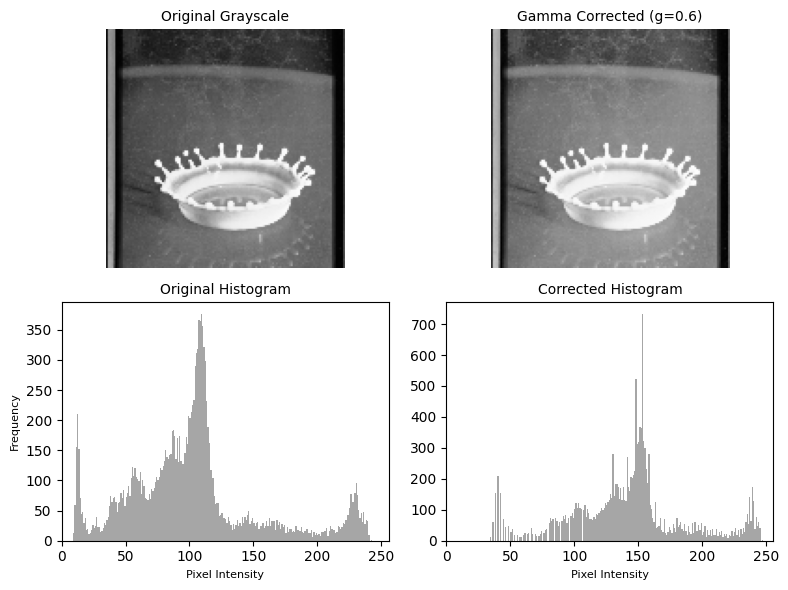

Justification:
I chose 'Power-Law (Gamma) Transformation' with gamma=0.6.
This technique is excellent for brightening dark images (if gamma < 1)
or darkening washed-out images, allowing us to see details in shadowed regions.
The histogram comparison above shows how the pixel intensities were shifted.

--- TASK 2: Noise Reduction & Edge Detection ---


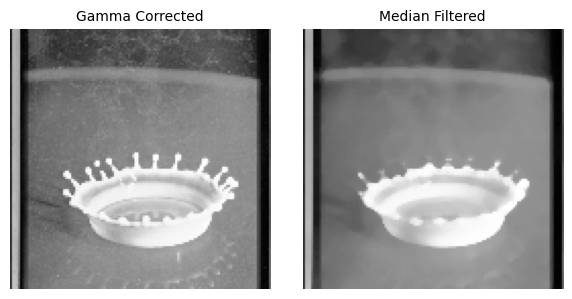

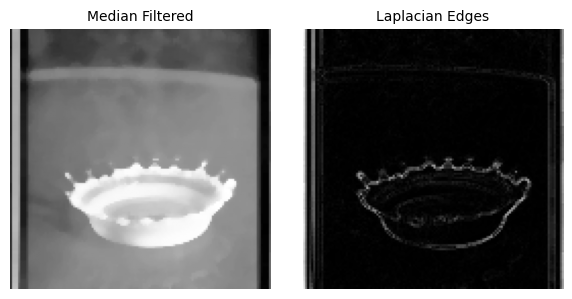


--- TASK 3: Segmentation & Feature Extraction ---


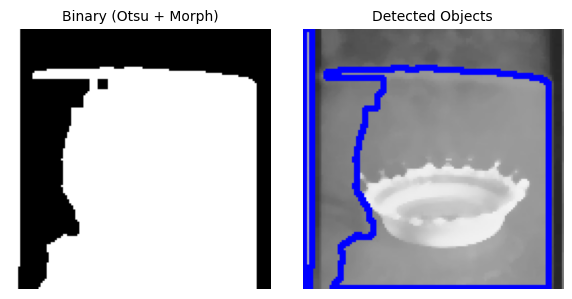


Final Feature Dictionary:
{'Intensity_Features': {'Mean': np.float64(164.92749752720079),
                        'Std_Dev': np.float64(31.385642284506822)},
 'Shape_Features': {'Area': 9878.0,
                    'Aspect_Ratio': 1.0091743119266054,
                    'Extent': 0.8238532110091743,
                    'Perimeter': 481.88224959373474},
 'Texture_GLCM': {'Contrast': np.float64(283.3615895669291),
                  'Correlation': np.float64(0.9248869024429993),
                  'Energy': np.float64(0.0658787422467776),
                  'Homogeneity': np.float64(0.5736038709756169)}}


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from google.colab import files
import pprint

class ImageAssignmentSolver:
    def __init__(self):
        self.original = None
        self.gray = None
        self.processed = None
        self.binary = None

    def upload_and_load(self):
        print("--- STEP 0: Upload Image ---")
        uploaded = files.upload()
        filename = next(iter(uploaded))
        self.original = cv2.imread(filename)

        # Convert to Grayscale
        if len(self.original.shape) == 3:
            self.gray = cv2.cvtColor(self.original, cv2.COLOR_BGR2GRAY)
        else:
            self.gray = self.original.copy()

    def show_comparison(self, img1, img2, title1, title2):
        # CHANGED: Reduced size from (10, 5) to (6, 3)
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(img1, cmap='gray')
        plt.title(title1, fontsize=10)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2, cmap='gray')
        plt.title(title2, fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def task1_gamma_correction(self, gamma=0.5):
        print(f"\n--- TASK 1: Power-Law (Gamma) Transformation (Gamma={gamma}) ---")

        # Normalize to range 0-1 for math, then apply power, then scale back to 255
        img_float = self.gray / 255.0
        corrected = np.power(img_float, gamma)
        corrected = np.uint8(corrected * 255)

        self.processed = corrected

        # CHANGED: Reduced grid size from (12, 8) to (8, 6)
        plt.figure(figsize=(8, 6))

        # 1. Original Image
        plt.subplot(2, 2, 1)
        plt.imshow(self.gray, cmap='gray')
        plt.title("Original Grayscale", fontsize=10)
        plt.axis('off')

        # 2. Corrected Image
        plt.subplot(2, 2, 2)
        plt.imshow(corrected, cmap='gray')
        plt.title(f"Gamma Corrected (g={gamma})", fontsize=10)
        plt.axis('off')

        # 3. Original Histogram
        plt.subplot(2, 2, 3)
        plt.hist(self.gray.ravel(), 256, [0, 256], color='gray', alpha=0.7)
        plt.title("Original Histogram", fontsize=10)
        plt.xlabel("Pixel Intensity", fontsize=8)
        plt.ylabel("Frequency", fontsize=8)
        plt.xlim([0, 256])

        # 4. Corrected Histogram
        plt.subplot(2, 2, 4)
        plt.hist(corrected.ravel(), 256, [0, 256], color='gray', alpha=0.7)
        plt.title("Corrected Histogram", fontsize=10)
        plt.xlabel("Pixel Intensity", fontsize=8)
        plt.xlim([0, 256])

        plt.tight_layout()
        plt.show()

        print("Justification:")
        print(f"I chose 'Power-Law (Gamma) Transformation' with gamma={gamma}.")
        print("This technique is excellent for brightening dark images (if gamma < 1)")
        print("or darkening washed-out images, allowing us to see details in shadowed regions.")
        print("The histogram comparison above shows how the pixel intensities were shifted.")

    def task2_median_laplacian(self):
        print("\n--- TASK 2: Noise Reduction & Edge Detection ---")

        # 1. Smoothing: Median Blur
        median_filtered = cv2.medianBlur(self.processed, 5)

        # 2. Edge Detection: Laplacian
        laplacian = cv2.Laplacian(median_filtered, cv2.CV_64F)
        laplacian_abs = cv2.convertScaleAbs(laplacian)

        self.show_comparison(self.processed, median_filtered, "Gamma Corrected", "Median Filtered")
        self.show_comparison(median_filtered, laplacian_abs, "Median Filtered", "Laplacian Edges")

        # Update current processed image
        self.processed = median_filtered

    def task3_segmentation_features(self):
        print("\n--- TASK 3: Segmentation & Feature Extraction ---")

        # 1. Segmentation: Otsu
        ret, self.binary = cv2.threshold(self.processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphological Closing
        kernel = np.ones((5,5), np.uint8)
        self.binary = cv2.morphologyEx(self.binary, cv2.MORPH_CLOSE, kernel)

        # 2. Contours
        contours, _ = cv2.findContours(self.binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contour_img = cv2.cvtColor(self.processed, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 2)

        self.show_comparison(self.binary, contour_img, "Binary (Otsu + Morph)", "Detected Objects")

        # 3. Features
        if contours:
            cnt = max(contours, key=cv2.contourArea)

            # Geometric
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            x,y,w,h = cv2.boundingRect(cnt)
            aspect_ratio = float(w)/h
            extent = float(area)/(w*h)

            # Statistical
            mask = np.zeros(self.binary.shape, np.uint8)
            cv2.drawContours(mask, [cnt], -1, 255, -1)
            mean, std = cv2.meanStdDev(self.processed, mask=mask)

            # GLCM Features
            glcm = graycomatrix(self.processed, [1], [0], 256, symmetric=True, normed=True)

            features = {
                "Shape_Features": {
                    "Area": area,
                    "Perimeter": perimeter,
                    "Aspect_Ratio": aspect_ratio,
                    "Extent": extent
                },
                "Intensity_Features": {
                    "Mean": mean[0][0],
                    "Std_Dev": std[0][0]
                },
                "Texture_GLCM": {
                    "Contrast": graycoprops(glcm, 'contrast')[0, 0],
                    "Energy": graycoprops(glcm, 'energy')[0, 0],
                    "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
                    "Correlation": graycoprops(glcm, 'correlation')[0, 0]
                }
            }

            print("\nFinal Feature Dictionary:")
            pprint.pprint(features)
        else:
            print("No contours found.")

# ==========================================
# MAIN EXECUTION
# ==========================================
solver = ImageAssignmentSolver()

# Step 0: Upload
solver.upload_and_load()

# Step 1: Gamma Correction
solver.task1_gamma_correction(gamma=0.6)

# Step 2: Median Blur + Laplacian Edge Detector
solver.task2_median_laplacian()

# Step 3: Segmentation with Morphological cleanup + Features
solver.task3_segmentation_features()